# Gradient Boosting

In [24]:
#to process data
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [25]:
#import data and convert bool features to numerical
bool_converter = lambda x: 1 if x == 't' else 0
train_df = pd.read_csv(
    "train.csv",
    converters={
        'Host_is_superhost':bool_converter,
        'Host_has_profile_pic': bool_converter,
        'Host_identity_verified':bool_converter,
        'Instant_bookable':bool_converter
    },
)

test_df = pd.read_csv(
    "test.csv",
    converters={
        'Host_is_superhost':bool_converter,
        'Host_has_profile_pic': bool_converter,
        'Host_identity_verified':bool_converter,
        'Instant_bookable':bool_converter
    }
)

In [26]:
#We drop 4 features in total: 'Bedrooms', 'Beds','Month''Host_has_profile_pic'
train_df = train_df.drop(columns = ['Bedrooms', 'Beds','Month','Host_has_profile_pic'])
test_df = test_df.drop(columns = ['Bedrooms', 'Beds','Month','Host_has_profile_pic'])

In [5]:
columns = ['id', 'Decision', 'Host_response_time',
           'Host_is_superhost', 'Host_has_profile_pic', 'Host_identity_verified','Neighbourhood',
           'Property_type', 'Room_type', 'Accommodates','Bathrooms_text',
           'Bedrooms', 'Beds',
           'Essentials', 'Cooking',
           'Balcony', 'Parking',
           'Price',
           'Number_of_reviews',
           'Review_scores_rating',
           'Instant_bookable',
           'Month']
#we can split features like below:
categorical = ['Neighbourhood', 'Host_response_time','Property_type', 'Room_type','Bathrooms_text']
continuous = ['Accommodates','Balcony', 'Parking','Essentials', 'Cooking',
              'Price','Review_scores_rating','Number_of_reviews']
binary = ['Host_is_superhost', 'Host_identity_verified','Instant_bookable']

In [6]:
#fill nan values
train_df.isna().sum()

id                          0
Decision                    0
Host_response_time        858
Host_is_superhost           0
Host_identity_verified      0
Neighbourhood               0
Property_type               0
Room_type                   0
Accommodates                0
Bathrooms_text              0
Essentials                  0
Cooking                     0
Balcony                     0
Parking                     0
Price                       0
Number_of_reviews           0
Review_scores_rating      395
Instant_bookable            0
dtype: int64

In [7]:
test_df.isna().sum()

id                          0
Host_response_time        293
Host_is_superhost           0
Host_identity_verified      0
Neighbourhood               0
Property_type               0
Room_type                   0
Accommodates                0
Bathrooms_text              0
Essentials                  0
Cooking                     0
Balcony                     0
Parking                     0
Price                       0
Number_of_reviews           0
Review_scores_rating      274
Instant_bookable            0
dtype: int64

In [8]:
train_df["Host_response_time"] = train_df["Host_response_time"].fillna(value="missing") 
test_df["Host_response_time"] = test_df["Host_response_time"].fillna(value="missing")

In [9]:
#still have a feature with nan values: fill it with median
train_df["Review_scores_rating"].median()

4.93

In [10]:
train_df["Review_scores_rating"] = train_df["Review_scores_rating"].fillna(value=4.93) #median
test_df["Review_scores_rating"] = test_df["Review_scores_rating"].fillna(value=4.93)

In [11]:
#price features: str to numerical
train_df['Price'] = train_df['Price'].replace({'\$':'',',':''},regex = True)
train_df['Price'] = train_df['Price'].astype('float')

test_df['Price'] = test_df['Price'].replace({'\$':'',',':''},regex = True)
test_df['Price'] = test_df['Price'].astype('float')


In [12]:
# continuous features require normalization
# normalize the continuous features to zero mean and unit variancee
scaler = StandardScaler()
scaler.fit(train_df[continuous])
train_df[continuous] = scaler.transform(train_df[continuous])
test_df[continuous] = scaler.transform(test_df[continuous])

In [13]:
#split labels and features
y_train_full = train_df['Decision']
X_train_full = train_df.drop(['Decision'], axis=1)

In [14]:
# convert categorical features to one-hot representations
len_train = len(X_train_full)

total_X = X_train_full.append(test_df, ignore_index=True)
one_hot_X = pd.get_dummies(total_X, columns=categorical)
#split train and test dataset
X_test = one_hot_X[len_train:]
X_train_full = one_hot_X[:len_train]

In [15]:
X_test

,id,Host_is_superhost,Host_identity_verified,Accommodates,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,...,Bathrooms_text_4.5 baths,Bathrooms_text_5 baths,Bathrooms_text_5.5 baths,Bathrooms_text_6 baths,Bathrooms_text_6.5 baths,Bathrooms_text_7 baths,Bathrooms_text_7.5 baths,Bathrooms_text_9 baths,Bathrooms_text_Half-bath,Bathrooms_text_Private half-bath
7471,1,1,1,-1.192110,-1.171512,-0.385235,0.763000,0.208063,-0.724997,0.462257,...,0,0,0,0,0,0,0,0,0,0
7472,2,1,1,-0.830126,0.447498,0.843931,0.763000,0.208063,-0.621800,4.532375,...,0,0,0,0,0,0,0,0,0,0
7473,3,1,1,-0.830126,0.447498,0.843931,0.763000,0.208063,-0.621800,4.691072,...,0,0,0,0,0,0,0,0,0,0
7474,4,1,1,-0.830126,0.447498,0.843931,0.763000,0.208063,-0.621800,4.784424,...,0,0,0,0,0,0,0,0,0,0
7475,5,1,1,-0.830126,0.447498,0.843931,0.763000,0.208063,-0.621800,4.607056,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9906,2436,0,0,0.617810,-6.028541,-2.228985,-1.310616,0.208063,-0.398208,-0.816656,...,0,0,0,0,0,0,0,0,0,0
9907,2437,1,1,1.703762,0.447498,0.843931,0.763000,0.208063,-0.352343,-0.816656,...,0,0,0,0,0,0,0,0,0,0
9908,2438,1,1,3.513681,-1.171512,-1.614402,-1.310616,0.208063,2.846753,-0.816656,...,0,0,0,0,0,0,0,0,0,0
9909,2439,1,1,-0.830126,0.447498,-0.999819,-1.310616,0.208063,-0.747930,-0.816656,...,0,0,0,0,0,0,0,0,0,0


In [16]:
X_train_full = X_train_full.drop(['id'], axis=1)
test_index =X_test['id']
#ids = ids.astype(np.int64)
X_test = X_test.drop(['id'], axis=1)

In [17]:
#split validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

### XGBoost

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [19]:
#hyperparameter selection
param_test1 = {
 'max_depth': range(3, 15,2 )
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate=0.1, n_estimators=1100,
 min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=42),
 param_grid = param_test1, scoring='accuracy',n_jobs=4, cv=3)
gsearch1.fit(X_train_full, y_train_full)
print(gsearch1.best_params_)
print(gsearch1.best_score_)

/Users/libertyeagle/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/Users/libertyeagle/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:37:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'max_depth': 11}
0.8000254732297315


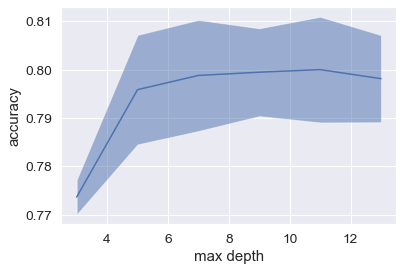

In [22]:
cv_results = gsearch1.cv_results_
params = list(range(3, 15, 2))
mean_test_score = cv_results["mean_test_score"]
std_test_score = cv_results["std_test_score"]
sns.set(font_scale = 1.25)
ax = sns.lineplot(x=params, y=mean_test_score)
ax.fill_between(params, y1=mean_test_score - std_test_score, y2=mean_test_score + std_test_score, alpha=.5)
ax.set_xlabel("max depth")
ax.set_ylabel("accuracy")
plt.savefig("xgboost_max_depth.pdf", bbox_inches="tight")

In [23]:
#train on full train dataset
clf_xgb = xgb.XGBClassifier(learning_rate=0.1, n_estimators=1100,
 min_child_weight=1, gamma=0.1,  max_depth=11, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=42)
t_start = time.time()
clf_xgb.fit(X_train_full,y_train_full)
t_end = time.time()
acc_train = clf_xgb.score(X_train_full,y_train_full)
print("train acc: {:.4f}".format(acc_train))
print("training time: {:.2f}".format(t_end - t_start))

/Users/libertyeagle/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train acc: 0.9916
training time: 23.86


In [28]:
preds = clf_xgb.predict(X_test)
results = pd.Series(preds, index=test_index)
results.to_csv("results/xgboost.csv", header=['Decision'], index=True, index_label='id')